# Plots and buildings

this notebook analyzes the geometries of plots and buildings and creates a dataset that can be used for training a model

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
import pandas as pd

import geopandas as gpd
import fiona
import shapely

import matplotlib.pyplot as plt
%matplotlib inline

## Load Cadastral Data: buildings and plots

In [4]:
# params
src = r"../../../../../../../SyntheticCitiesData/"

In [5]:
geolcf = gpd.read_file(src + "av_lv95/geopackage/av_lv95.gpkg", layer = "lcsf") # surface

In [6]:
geores = gpd.read_file(src + "av_lv95/geopackage/av_lv95.gpkg", layer = "resf") # plots

In [7]:
geores.head()

BFSNr       NBIdent Nummer     EGRIS_EGRID Vollstaendigkeit  Flaeche  \
0     11  ZH0200000011   1325  CH219088907765     vollstaendig      520   
1     11  ZH0200000011    126  CH879077789079     vollstaendig      577   
2    152  ZH0200000152   3275  CH707714843583     vollstaendig      668   
3    152  ZH0200000152   3277  CH711484357714     vollstaendig      561   
4    152  ZH0200000152   5941  CH733577148483     vollstaendig      136   

      Gueltigkeit Kanton                                           geometry  
0  rechtskraeftig     ZH  POLYGON ((2673184.431 1237397.108, 2673193.467...  
1  rechtskraeftig     ZH  POLYGON ((2672678.721 1237398.82, 2672681.278 ...  
2  rechtskraeftig     ZH  POLYGON ((2689008.161 1238122.283, 2689018.279...  
3  rechtskraeftig     ZH  POLYGON ((2689027.433 1238104.836, 2689042.357...  
4  rechtskraeftig     ZH  POLYGON ((2688989.988 1238038.658, 2689004.923...

### Geometries in the municipality Zurich

In [8]:
geobrd = gpd.read_file(src + "swissBOUNDARIES3D_1_5_LV95_LN02.gdb/",  driver='FileGDB', layer = "TLM_HOHEITSGEBIET")
geozhc = geobrd.loc[geobrd.BFS_NUMMER == 261] # selecting Zuerich geometry to simplify the experiment

C:\Users\furio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(


In [9]:
# surfaces
geolcfzh = gpd.sjoin(geolcf, geozhc, how='inner', predicate='within')
geolcfzh = geolcfzh.drop(['index_right'], axis=1)

# plots
georeszh = gpd.sjoin(geores, geozhc, how='inner', predicate='within')
georeszh = georeszh.drop(['index_right'], axis=1)

C:\Users\furio\AppData\Local\Temp\ipykernel_23896\2382698480.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2056
Right CRS: COMPD_CS["CH1903+ / LV95 + LN02 height",PROJCS["CH ...

  geolcfzh = gpd.sjoin(geolcf, geozhc, how='inner', predicate='within')
C:\Users\furio\AppData\Local\Temp\ipykernel_23896\2382698480.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2056
Right CRS: COMPD_CS["CH1903+ / LV95 + LN02 height",PROJCS["CH ...

  georeszh = gpd.sjoin(geores, geozhc, how='inner', predicate='within')


### Selecting building surfaces

In [10]:
geobldzh = geolcfzh[geolcfzh.Art == 'Gebaeude']

### Representing the output

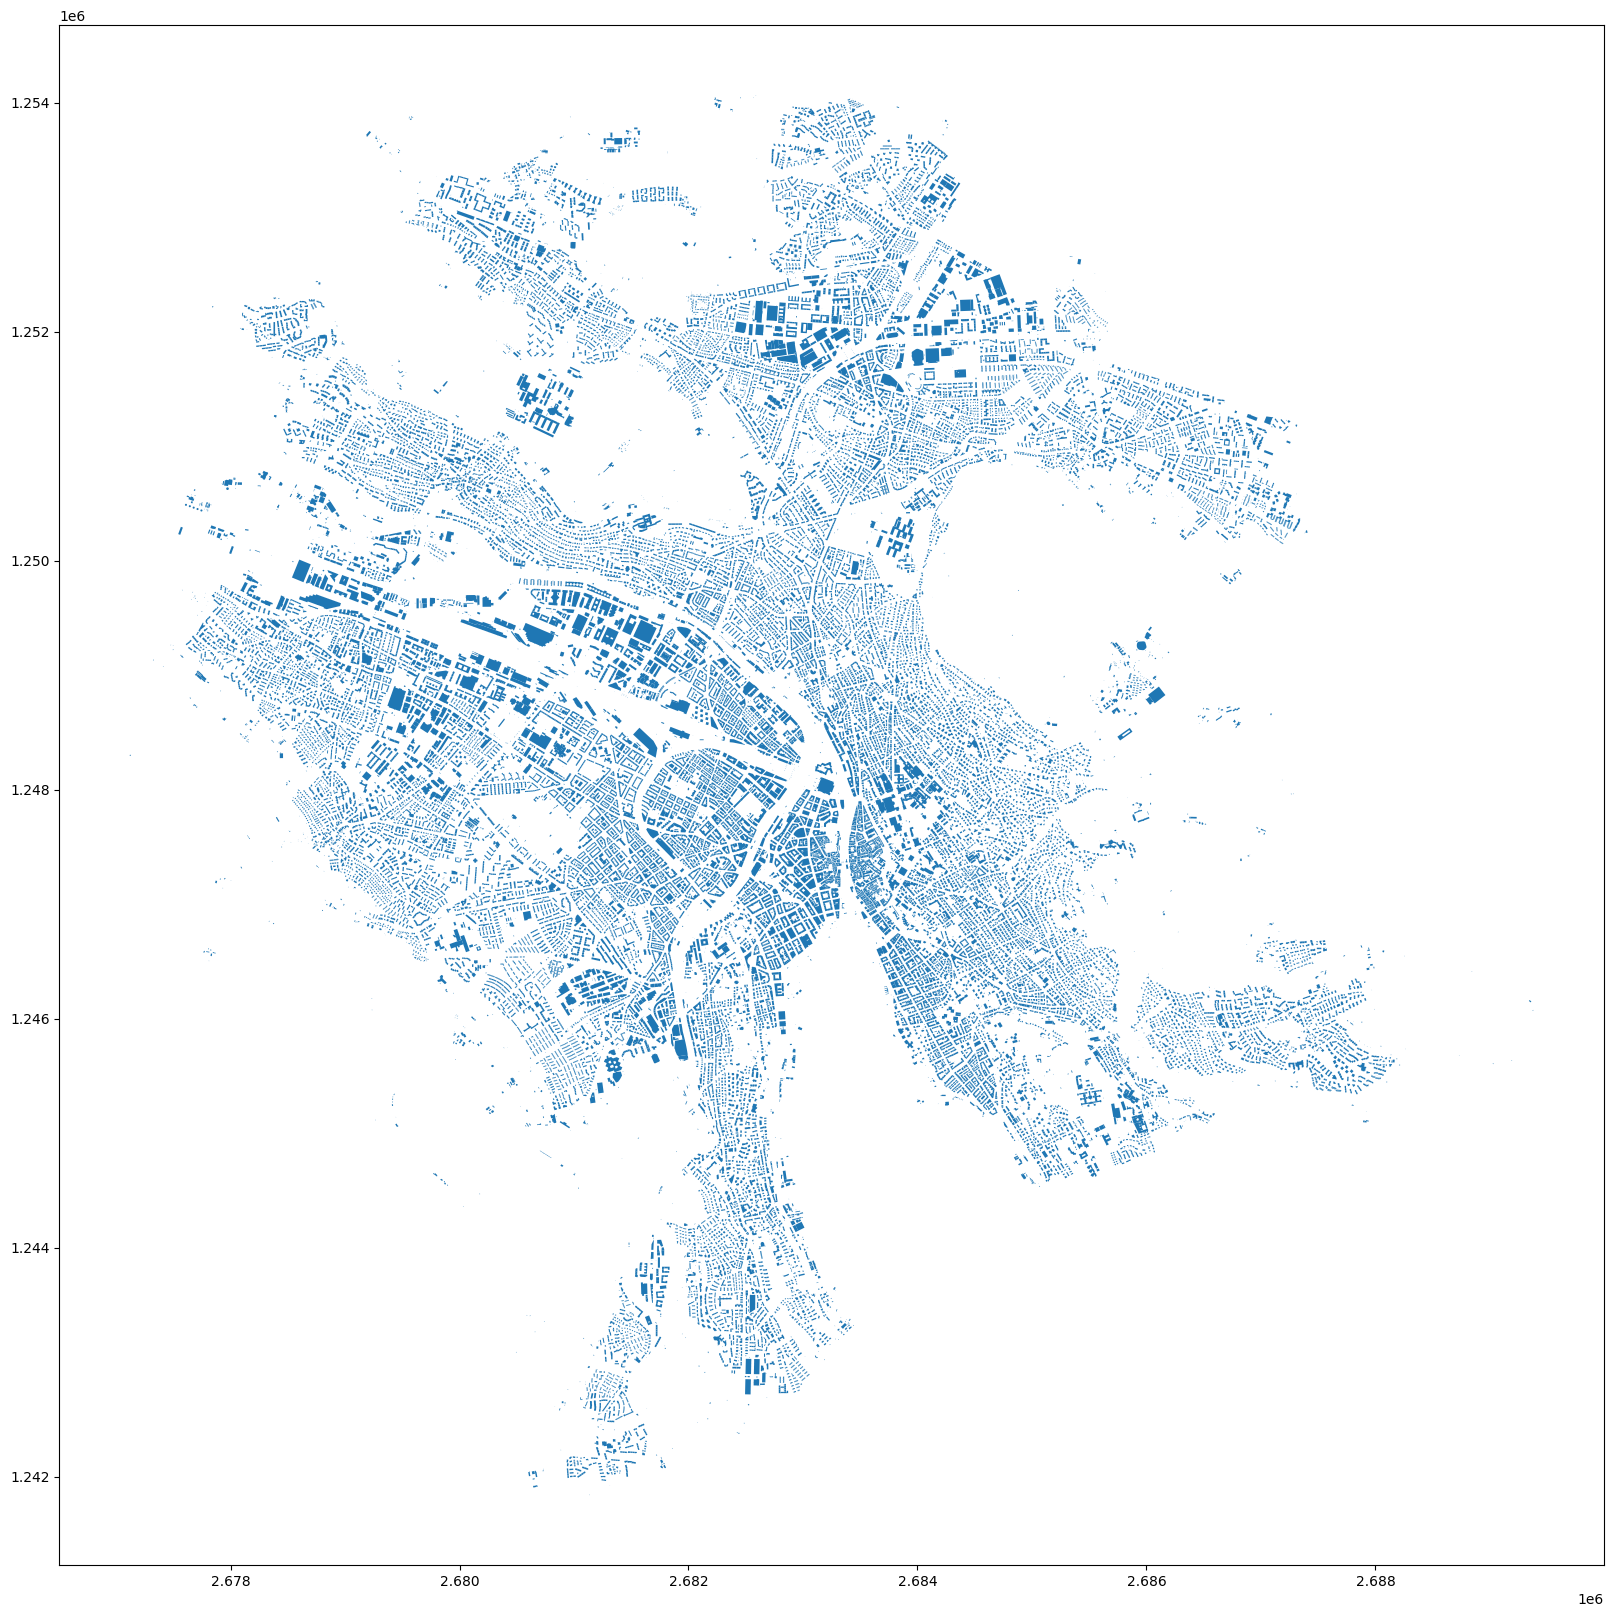

In [11]:
geobldzh.plot(figsize = (30,20));

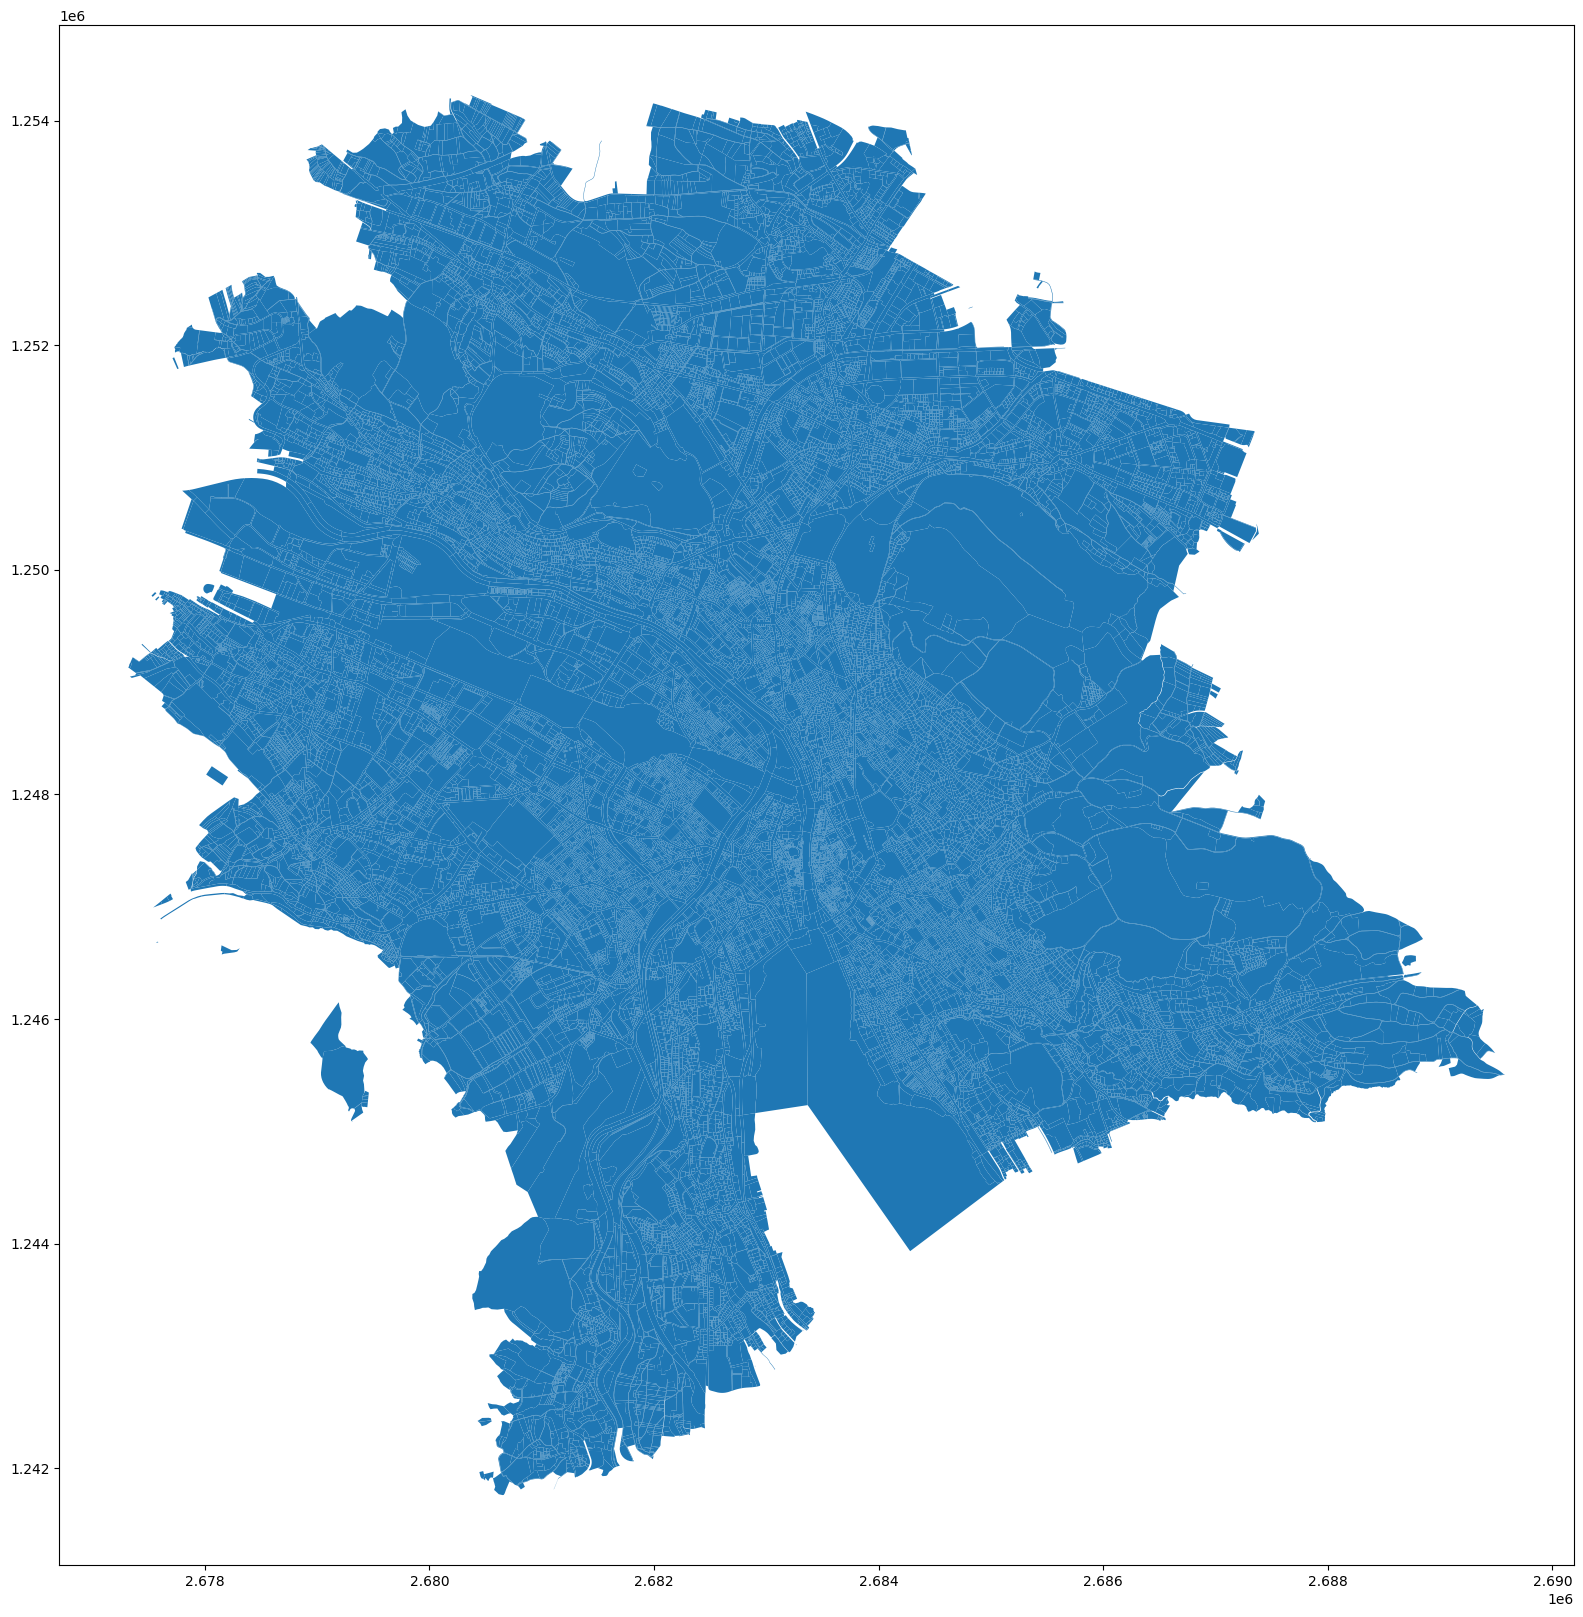

In [12]:
georeszh.plot(figsize = (30,20));

## Selecting only the plots with buildings

In [306]:
georeszh.shape

(39316, 34)

Each plt should have an unique identifier:

In [308]:
len(georeszh.EGRIS_EGRID.unique())

39316

Performing spatial join to select plots with buildings

In [307]:
georeszh_with_buildings = gpd.sjoin(georeszh, geobldzh, how='inner', predicate='contains')

In [309]:
len(georeszh_with_buildings.EGRIS_EGRID.unique())

21597

In [60]:
georeszh_with_buildings.shape

(38738, 65)

removing unnecessary columns

In [61]:
georeszh_with_buildings = georeszh_with_buildings.drop(georeszh_with_buildings.columns[34:], axis=1)
georeszh_with_buildings.shape

(38738, 34)

removing duplicates

In [62]:
georeszh_with_buildings = georeszh_with_buildings.drop_duplicates()
georeszh_with_buildings.shape

(21597, 34)

Plots without buildings

In [63]:
# plots without buildings
georeszh_without_blds = georeszh[~georeszh.apply(tuple,1).isin(georeszh_with_buildings.apply(tuple,1))]

In [64]:
georeszh_without_blds.shape

(17719, 34)

## Adding the Plot EGRID identifier to the building table
the EGRID identifier is the unique identifier for plots. So it will be possible to relate plot coordinates to the relative building coordinates

In [310]:
geobldzh_with_egrid = gpd.sjoin(geobldzh, georeszh, how='left', predicate='within', lsuffix='')

In [311]:
len(geobldzh_with_egrid.EGRIS_EGRID.unique())


21598

Removing unnecessary columns, keeping only the index and the EGRID of the second database

In [312]:
cols_to_drop = georeszh.columns
cols_to_drop = cols_to_drop.drop(['EGRIS_EGRID', 'geometry'])
cols_to_drop = [c + "_right" if c in geobldzh.columns else c for c in cols_to_drop]

In [313]:
geobldzh_with_egrid = geobldzh_with_egrid.drop(cols_to_drop, axis=1)

In [314]:
geobldzh_with_egrid.columns = list(geobldzh.columns) + ['index_right', 'EGRIS_EGRID']

the spatial join created copies of buildings that touch two plots (built on the boarder). The code below removes the duplicates

In [315]:
geobldzh_with_egrid.shape

(48731, 34)

In [316]:
geobldzh.shape

(48731, 32)

In [317]:
# removing duplicates
geobldzh_with_egrid = geobldzh_with_egrid.drop_duplicates(subset='GWR_EGID', keep='first')

### Printing all plots and builings

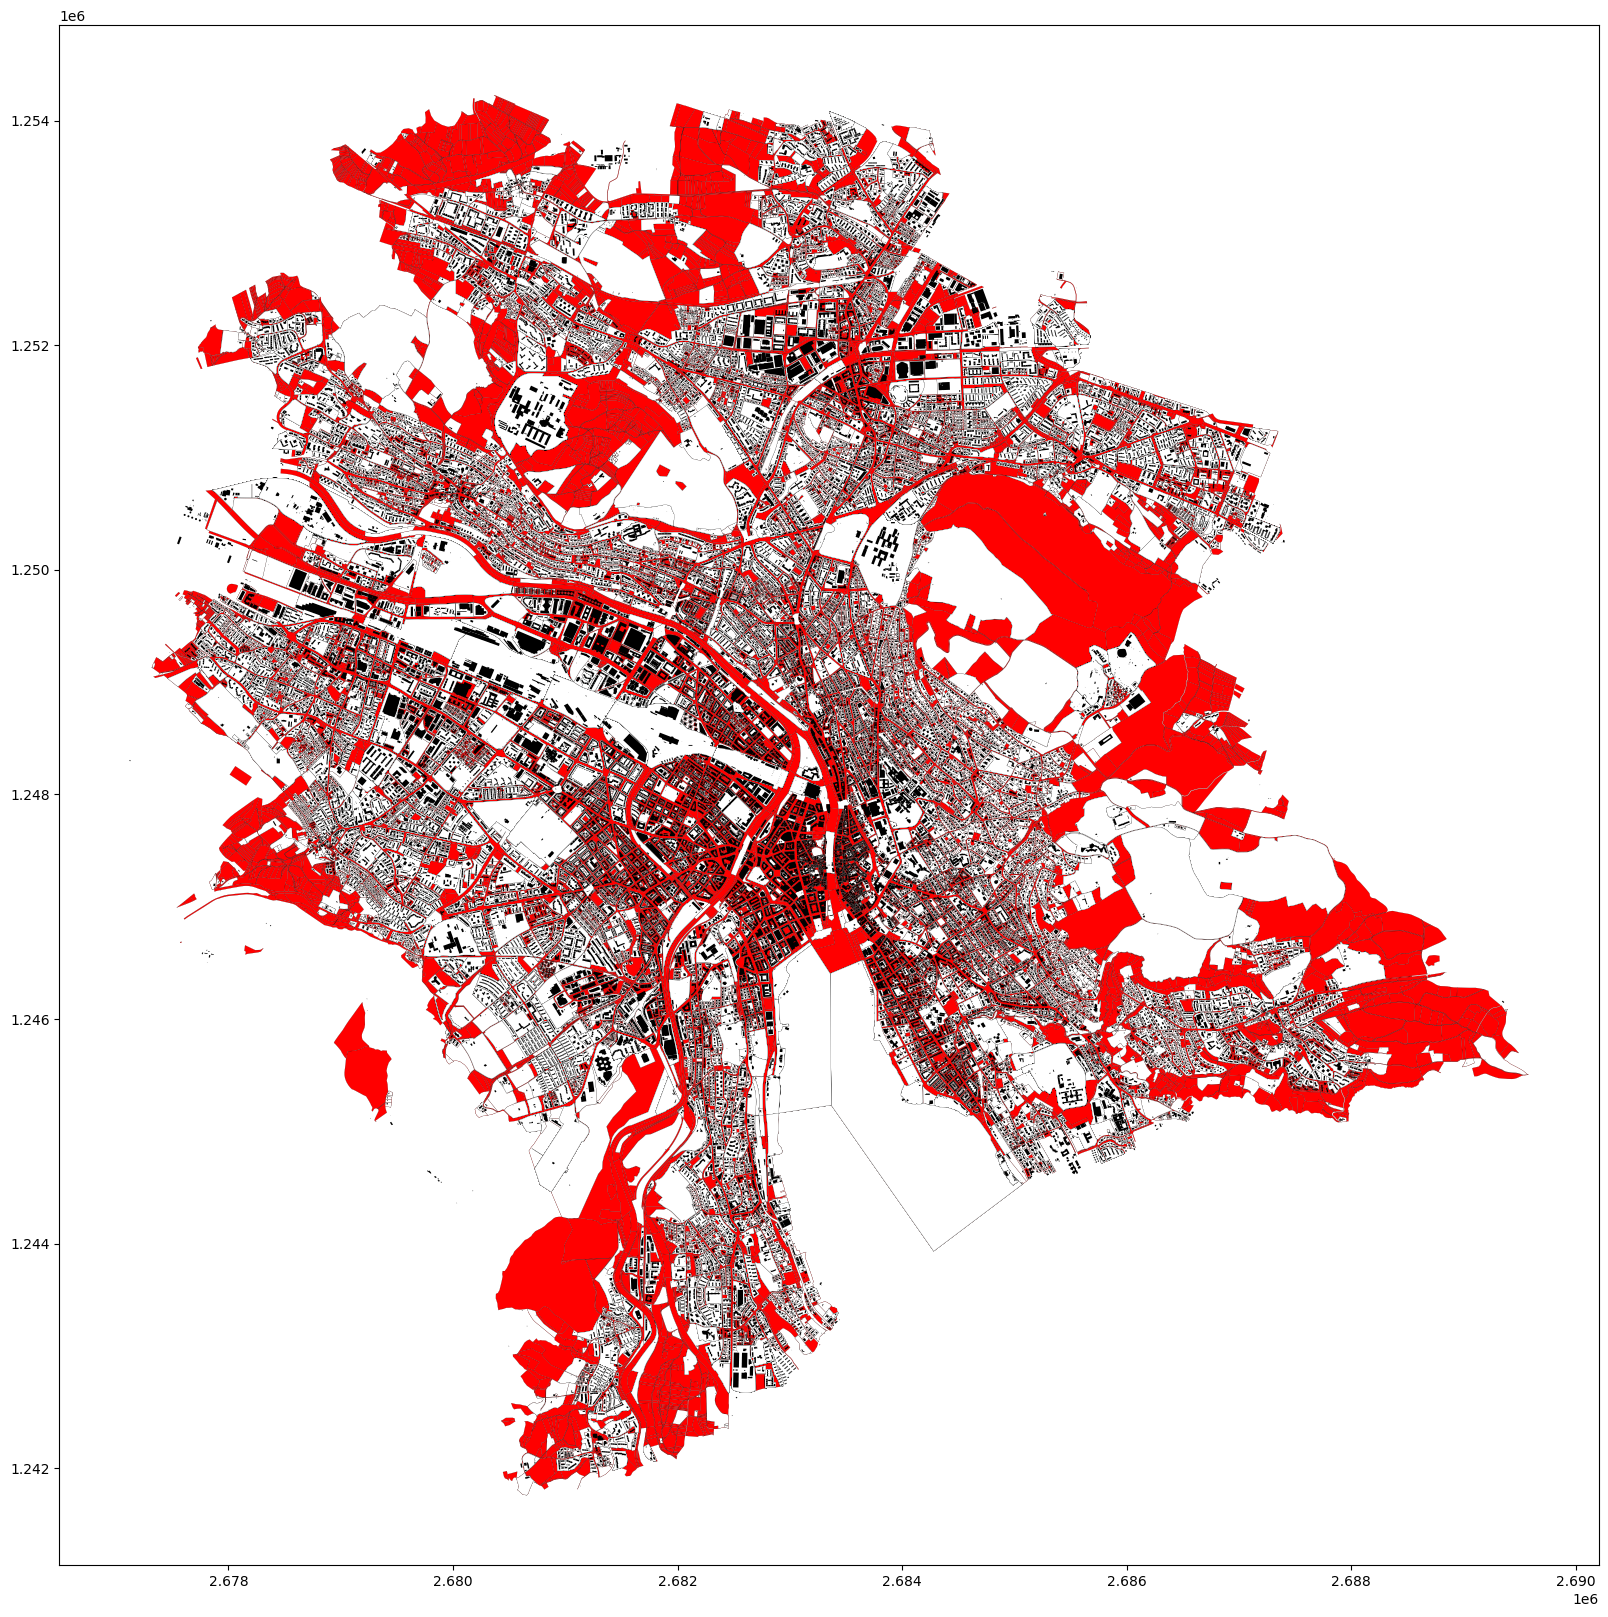

In [318]:
fig, ax = plt.subplots(figsize = (30,20))
georeszh.plot(ax = ax, color='red', edgecolor = 'black', linewidth = 0.1)
georeszh_with_buildings.plot(ax = ax, color = 'white', edgecolor = 'black', linewidth = 0.1)
geobldzh_with_egrid.plot(ax = ax, color = 'black');


## Counting the number of points in the plots

In [319]:
# Calculate the number of points in each geometry
georeszh_with_buildings['num_points'] = georeszh_with_buildings.geometry.apply(lambda geom: len(geom.exterior.coords) if geom.geom_type == 'Polygon' else sum(len(poly.exterior.coords) for poly in geom))

# Calculate the total number of points
total_points = georeszh_with_buildings['num_points'].sum()

print(f"Total number of points in the geodatabase georeszh_with_buildings: {total_points}")

Total number of points in the geodatabase georeszh_with_buildings: 1114432


95% of the plots have 92.0 or less points


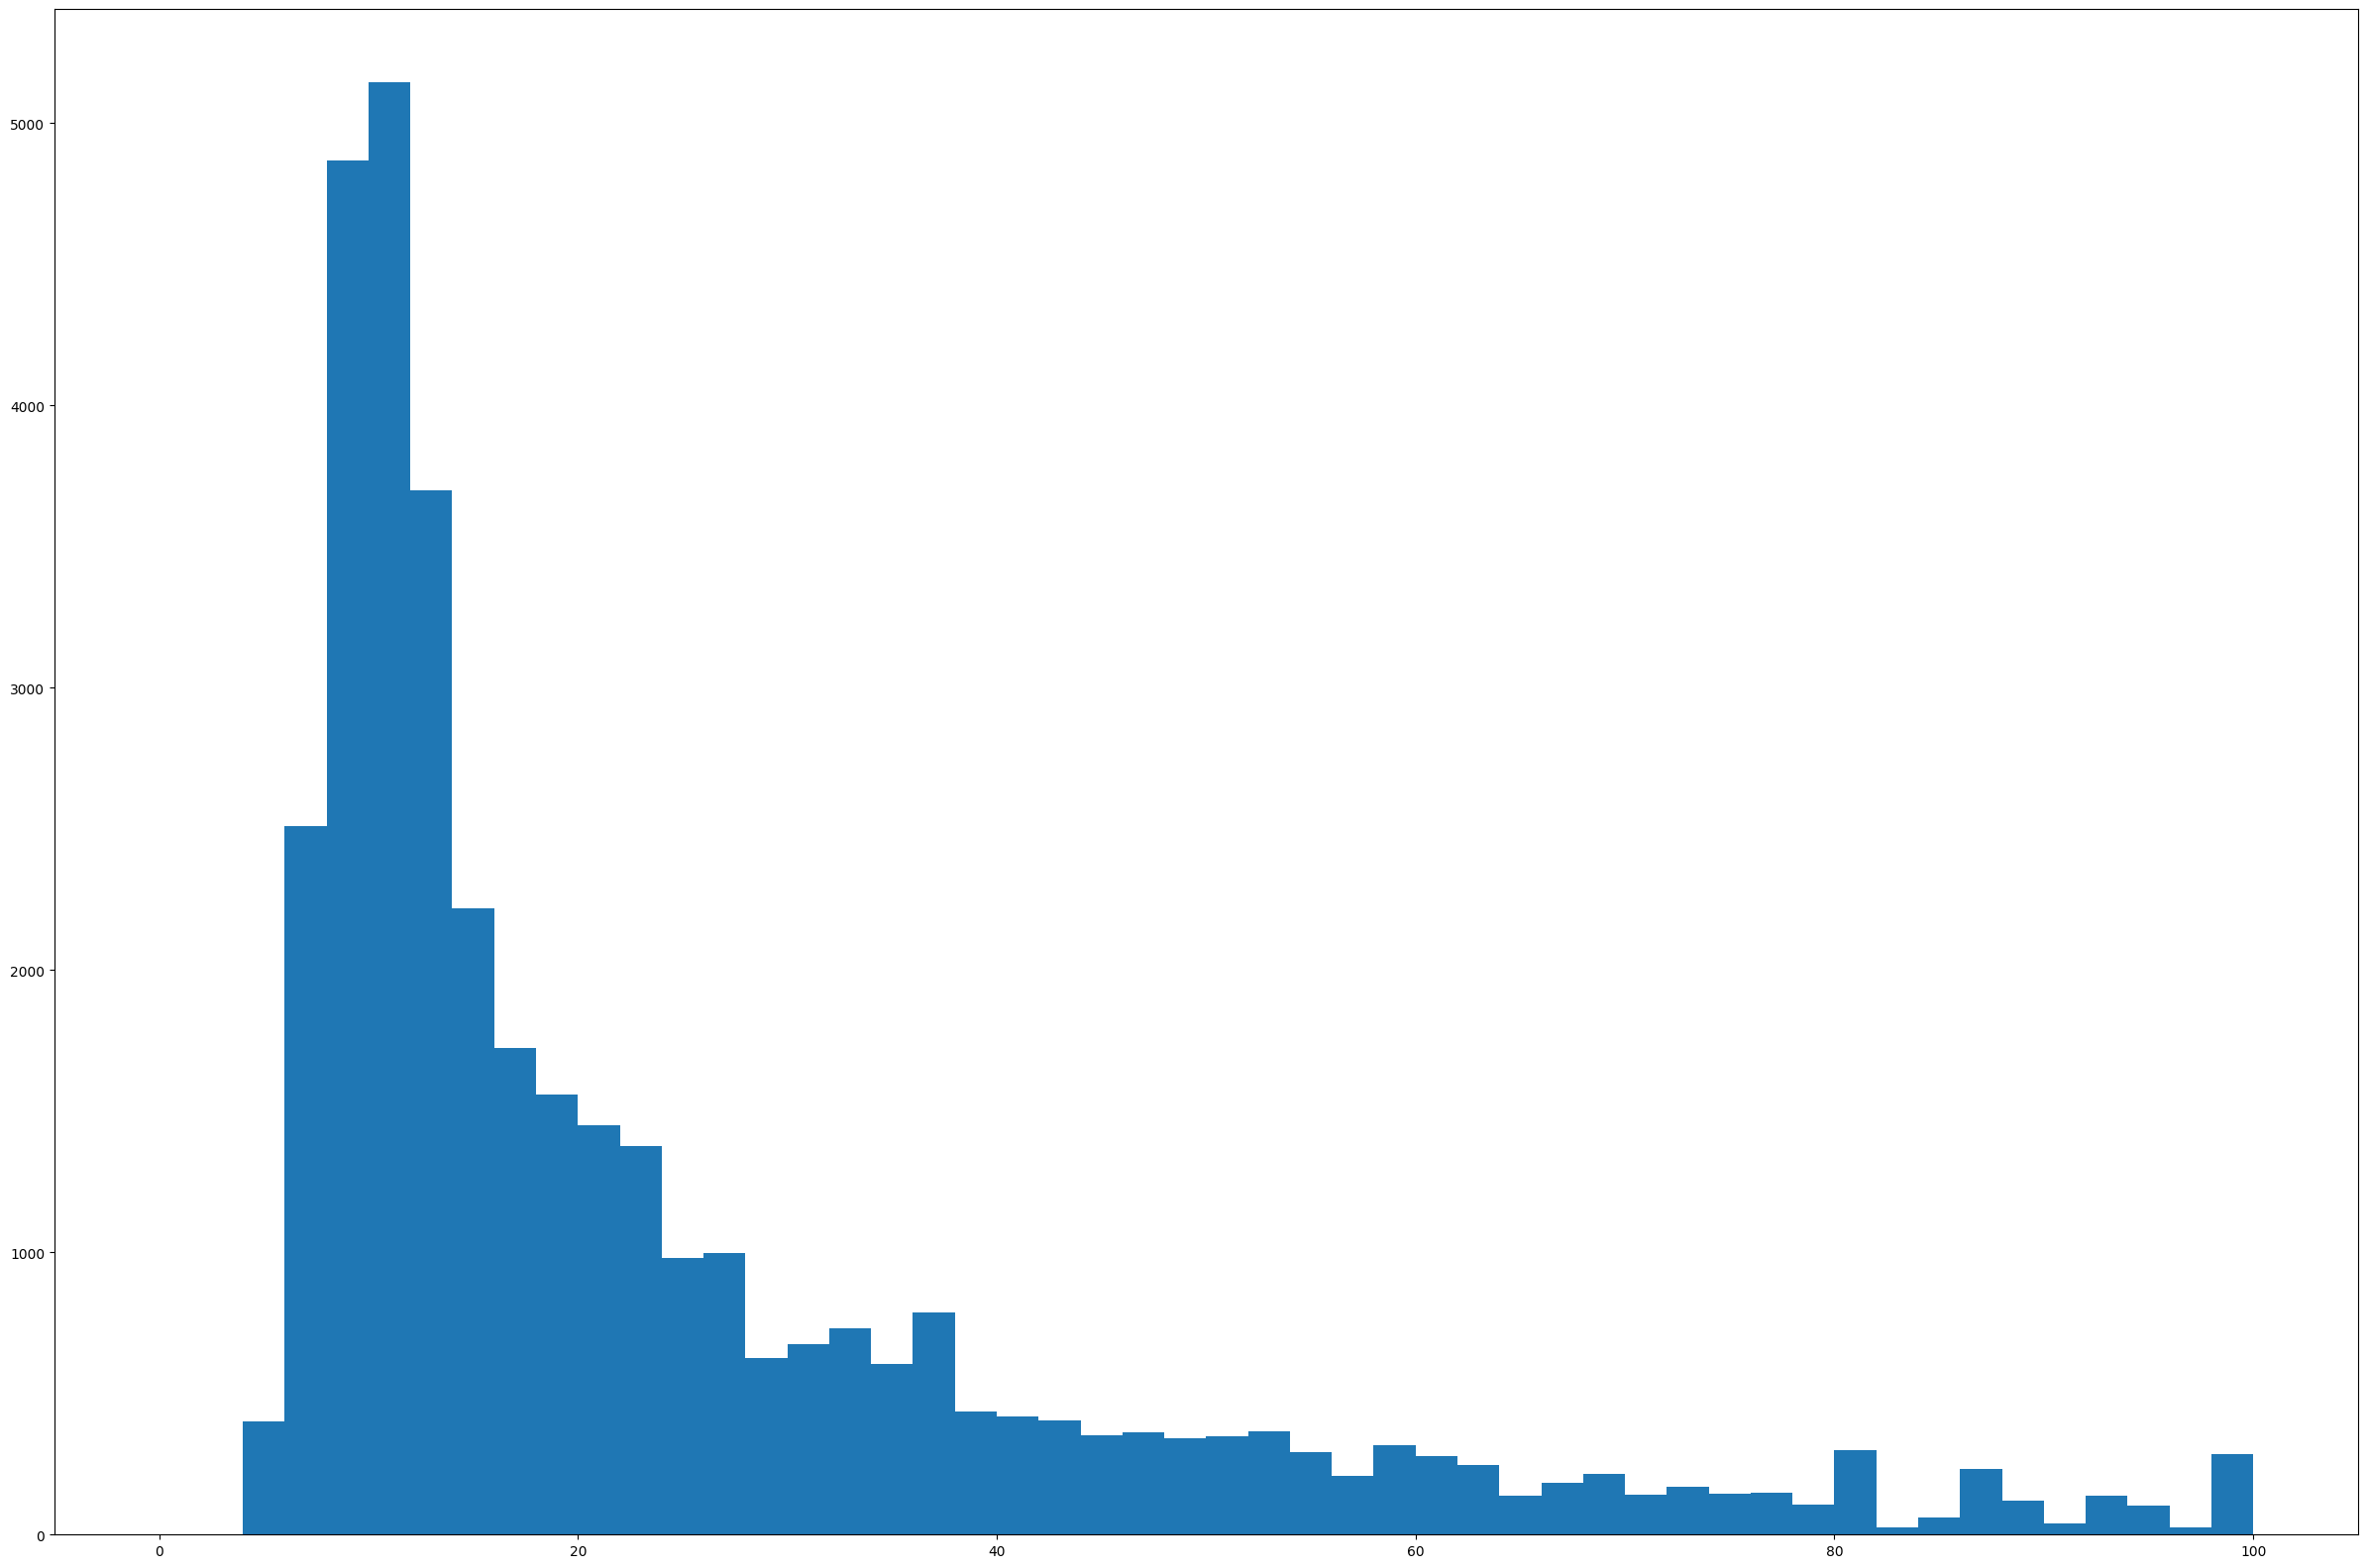

In [320]:
fig, ax = plt.subplots(figsize = (30, 20))
plt.hist(georeszh_with_buildings['num_points'], bins = 50, range=(0,100));
print(f"95% of the plots have {np.quantile(georeszh_with_buildings['num_points'], 0.95)} or less points")

## Counting the number of points in the buildings

95% of the building footprints have 29.0 or less points


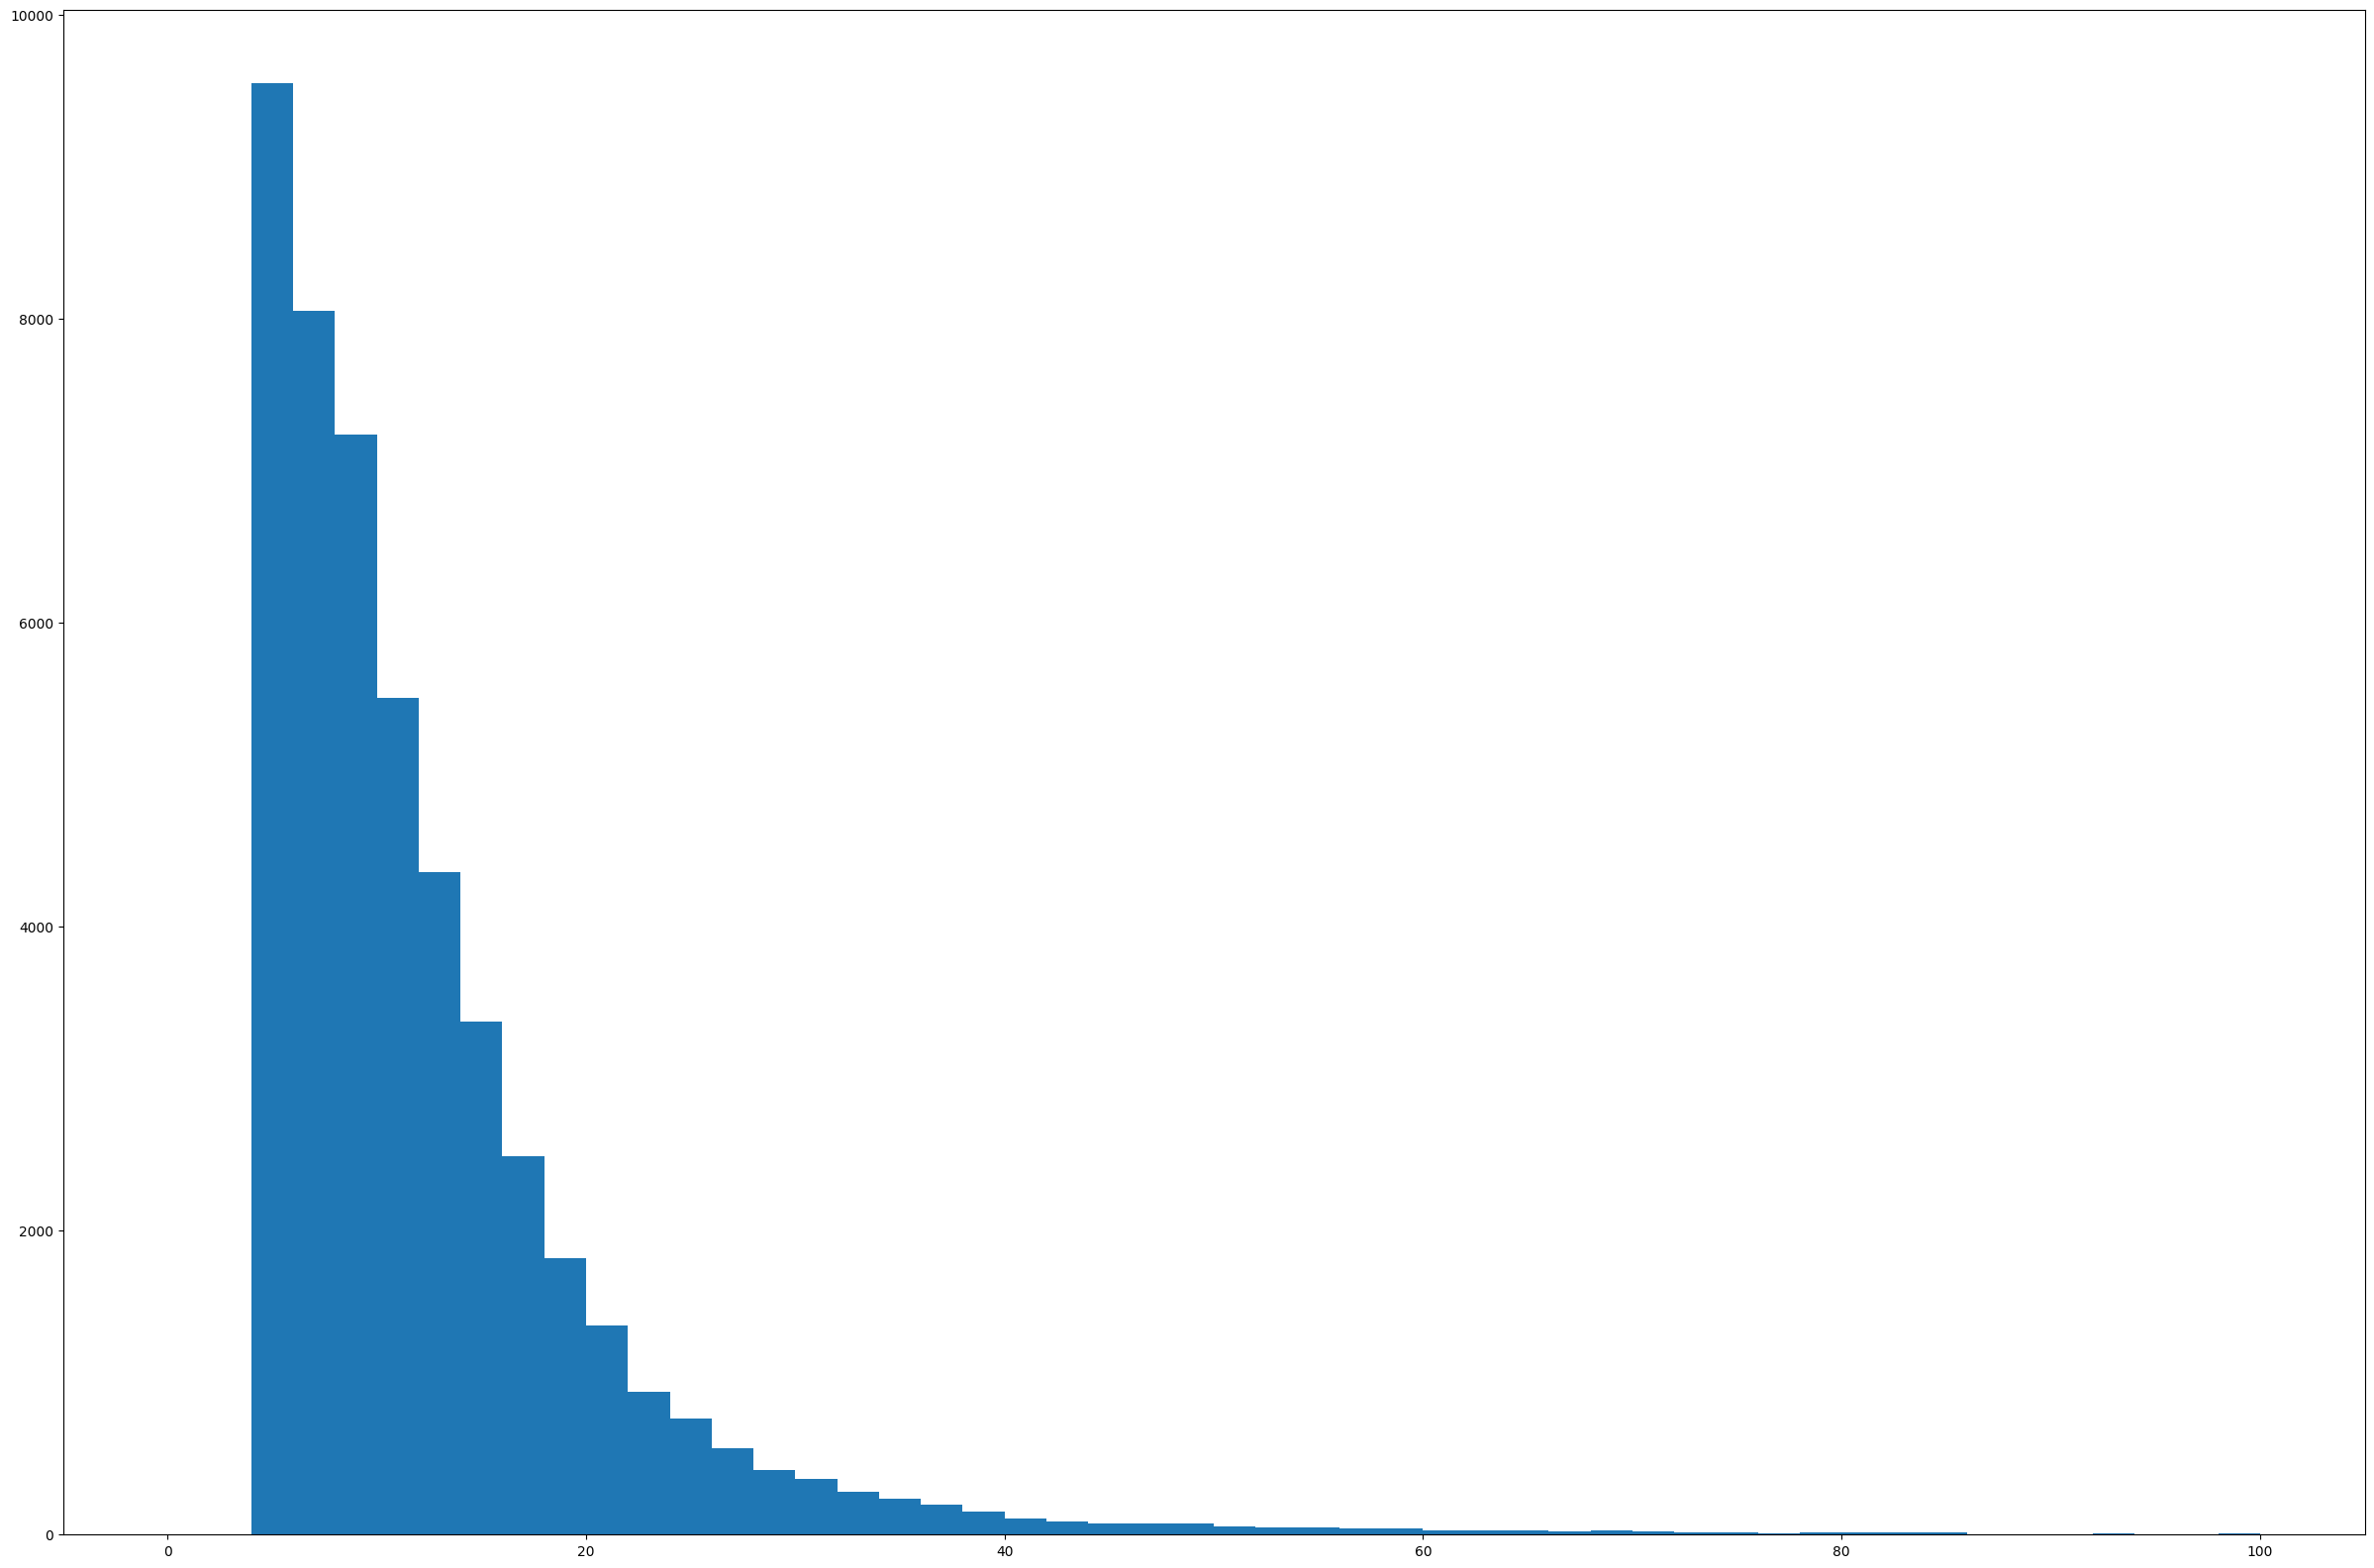

In [321]:
fig, ax = plt.subplots(figsize = (30, 20))
geobldzh_with_egrid['num_points'] = geobldzh_with_egrid.geometry.count_coordinates().values
print(f"95% of the building footprints have {np.quantile(geobldzh_with_egrid['num_points'], 0.95)} or less points")
plt.hist(geobldzh_with_egrid['num_points'], bins = 50, range=(0,100));

## Preparing plot and building coordinates for the export

In [327]:
def export_geometries(gdb: gpd.GeoDataFrame, maxPoints: int, bld: bool = True):

    if bld:
        # if exporting buildings
        res_cols = ['GWR_EGID', 'EGRIS_EGRID'] + ["X_" + str(n) for n in range(maxPoints)] + ["Y_" + str(n) for n in range(maxPoints)]
    else:
        # if exporting plots
        res_cols = ['EGRIS_EGRID'] + ["X_" + str(n) for n in range(maxPoints)] + ["Y_" + str(n) for n in range(maxPoints)]
    res = pd.DataFrame(columns=(res_cols), dtype=float)

    for index, row in gdb.iterrows():
        geom = row.geometry
        coords = list(geom.exterior.coords)
        if len(coords) <= maxPoints:
            # GWR_EGID / EGRIS_EGRID identifier
            identifier = row.iloc[3] # same position for both buildings and plots identifiers 'GWR_EGID' and 'EGRIS_EGRID'
            if bld:
                plot_identifier = row.loc['EGRIS_EGRID']
            # moving all the points to origin (x = 0, y = 0)
            xies = [coord[0] for coord in coords]
            minx = min(xies)
            xies = [x - minx for x in xies]
            yies = [coord[1] for coord in coords]
            miny = min(yies)
            yies = [y - miny for y in yies]
            # Pad the list with NaNs if it has less than max_points
            xies += [np.nan] * ( maxPoints- len(xies))
            yies += [np.nan] * ( maxPoints- len(yies))
            # Putting xies and yies together
            flat_coords = xies + yies
            if bld:
                row_data = [identifier, plot_identifier] + flat_coords
            else: 
                row_data = [identifier] + flat_coords
            res.loc[index] = row_data
    return res

In [346]:
maxPoints = int(np.quantile(geobldzh_with_egrid['num_points'], 0.95))
bld_coords = export_geometries(geobldzh_with_egrid, maxPoints, True) # should run in less than 7 mins

In [328]:
maxPointsPlt = int(np.quantile(georeszh_with_buildings.num_points, 0.95))
plt_coords = export_geometries(georeszh_with_buildings, maxPointsPlt, False)

## Export results as csv

In [347]:
bld_coords.to_csv(src + r'export/geozh_bld_coords.csv', sep = ';')

In [345]:
plt_coords.to_csv(src + r'export/geozh_plt_coords.csv', sep = ';')

# Archive

In [342]:
len(plt_coords.EGRIS_EGRID.unique())

21422

In [329]:
len(bld_coords.EGRIS_EGRID.unique())

20968

In [330]:
bld_coords.shape

(46480, 60)

In [331]:
len(geobldzh_with_egrid.EGRIS_EGRID.unique())

21598

In [332]:
len(georeszh_with_buildings.EGRIS_EGRID.unique())

21597

In [333]:
i = 4
row = geobldzh_with_egrid.iloc[i]
maxPoints = int(np.quantile(geobldzh_with_egrid['num_points'], 0.95))

geom = row.geometry
coords = list(geom.exterior.coords)
# moving all the points to origin (x = 0, y = 0)
xies = [coord[0] for coord in coords]
minx = min(xies)
xies = [x - minx for x in xies]
yies = [coord[1] for coord in coords]
miny = min(yies)
yies = [y - miny for y in yies]
if len(coords) <= maxPoints:
    # Pad the list with NaNs if it has less than max_points
    xies += [np.nan] * ( maxPoints- len(xies))
    yies += [np.nan] * ( maxPoints- len(yies))
    # Putting xies and yies together
    flat_coords = xies + yies
    # Pad the list with NaNs if it has less than max_points
    # flat_coords += [np.nan] * (2 * maxPoints - len(flat_coords))
    # res.loc[index] = flat_coords

In [334]:
len(geobldzh_with_egrid.EGRIS_EGRID.unique())

21598

In [335]:
len(georeszh)

39316

In [336]:
# geom.exterior.coords.xy
len(coords)

12

In [337]:
geobldzh_with_egrid.columns

Index(['BFSNr', 'Qualitaet', 'Art', 'GWR_EGID', 'Kanton', 'geometry',
       'Shape_Length', 'Shape_Area', 'UUID', 'DATUM_AENDERUNG',
       'DATUM_ERSTELLUNG', 'ERSTELLUNG_JAHR', 'ERSTELLUNG_MONAT',
       'GRUND_AENDERUNG', 'HERKUNFT', 'HERKUNFT_JAHR', 'HERKUNFT_MONAT',
       'REVISION_JAHR', 'REVISION_MONAT', 'REVISION_QUALITAET', 'OBJEKTART',
       'BFS_NUMMER', 'BEZIRKSNUMMER', 'KANTONSNUMMER', 'NAME', 'GEM_FLAECHE',
       'SEE_FLAECHE', 'ICC', 'SHN', 'EINWOHNERZAHL', 'HIST_NR', 'num_points',
       'index_right', 'EGRIS_EGRID'],
      dtype='object')

In [338]:
n = len(coords)
for i in range(n):
    print(f'difference original and transformed coords: {coords[i][0]-(flat_coords[i]+minx)}')

difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0
difference original and transformed coords: 0.0


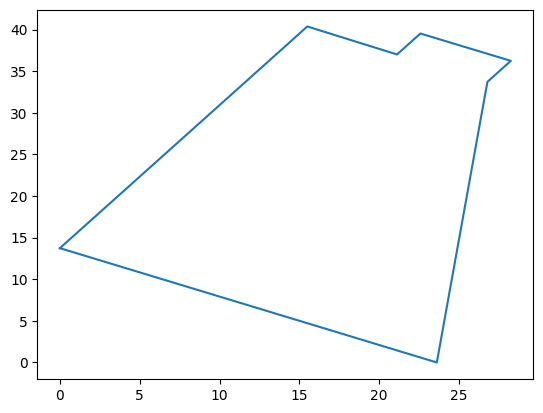

In [339]:
plt.plot(flat_coords[0:len(coords)], flat_coords[maxPoints:maxPoints+len(coords)]);

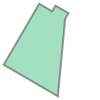

In [340]:
# plt.plot(row.geometry.exterior.coords.xy);
row.geometry

In [341]:
maxPoints = int(np.quantile(geobldzh_with_egrid['num_points'], 0.95))
bld_coords = export_geometries(geobldzh_with_egrid, maxPoints)

KeyboardInterrupt: 

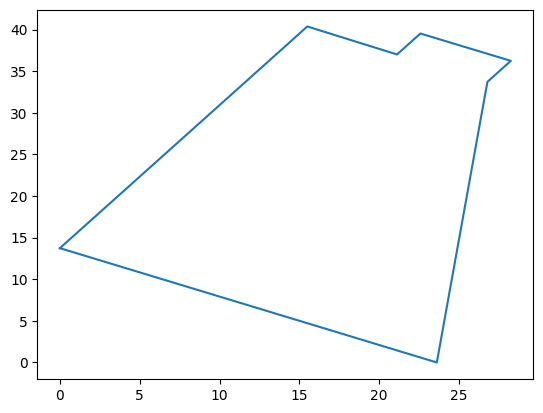

In [166]:
i = 0
bld = bld_coords.iloc[i]
x_coords = [bld["X_" + str(value)] for value in range(maxPoints) ]
y_coords = [bld["Y_" + str(value)] for value in range(maxPoints) ]
plt.plot(x_coords, y_coords);

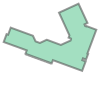

In [167]:
geobldzh.iloc[i].geometry

In [ ]:
x_coords

[np.float64(0.0),
 np.float64(10.239000000059605),
 np.float64(13.45699999993667),
 np.float64(14.376000000163913),
 np.float64(15.498999999836087),
 np.float64(21.12100000027567),
 np.float64(22.584000000264496),
 np.float64(28.248000000137836),
 np.float64(26.782000000122935),
 np.float64(26.177999999839813),
 np.float64(23.612999999895692),
 np.float64(0.0),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan)]

In [170]:
coords = list(geobldzh.iloc[i].geometry.exterior.coords)
coords

[(2679322.759, 1249920.608),
 (2679324.6890000002, 1249925.882),
 (2679324.876, 1249926.388),
 (2679326.012, 1249925.967),
 (2679327.936, 1249931.173),
 (2679330.791, 1249930.117),
 (2679337.77, 1249927.571),
 (2679344.259, 1249925.21),
 (2679346.203, 1249921.0590000001),
 (2679349.363, 1249919.901),
 (2679354.445, 1249922.269),
 (2679359.478, 1249920.406),
 (2679362.3850000002, 1249919.33),
 (2679364.782, 1249918.442),
 (2679368.287, 1249920.04),
 (2679371.92, 1249921.673),
 (2679372.341, 1249922.849),
 (2679372.205, 1249923.179),
 (2679370.504, 1249923.82),
 (2679371.122, 1249925.43),
 (2679368.151, 1249931.932),
 (2679363.455, 1249942.21),
 (2679377.8000000003, 1249948.793),
 (2679384.3540000003, 1249934.656),
 (2679382.18, 1249933.591),
 (2679382.7460000003, 1249932.328),
 (2679383.373, 1249932.105),
 (2679383.488, 1249932.383),
 (2679390.875, 1249929.6230000001),
 (2679384.327, 1249912.077),
 (2679384.87, 1249911.867),
 (2679383.335, 1249907.766),
 (2679381.072, 1249908.6130000001

In [ ]:
len(geobldzh.iloc[i].geometry.exterior.coords.xy[0])

46

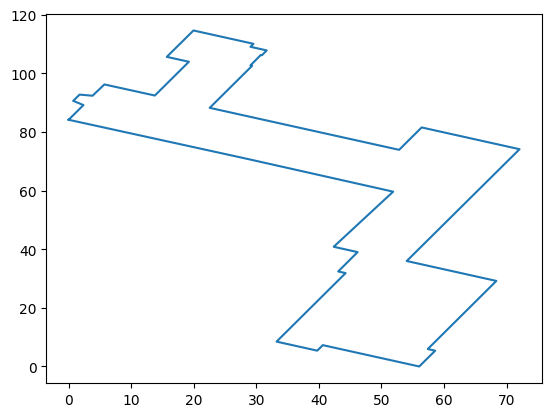

In [ ]:
xies = [coord[0] for coord in coords]
minx = min(xies)
xies = [x - minx for x in xies]
yies = [coord[1] for coord in coords]
miny = min(yies)
yies = [y - miny for y in yies]
plt.plot(xies, yies)

In [108]:
geobldzh.shape

(48731, 32)

In [ ]:
# Define the maximum number of points
max_points = 29

# Create a list of column names for the dataframe
columns = [f'X_{i}' for i in range(max_points)] + [f'Y_{i}' for i in range(max_points)]

# Initialize an empty dataframe with the defined columns
df_coordinates = pd.DataFrame(columns=columns)

# Iterate over the geometries in geobldzh
for idx, row in geobldzh.iterrows():
    geom = row.geometry
    if geom.geom_type == 'Polygon':
        coords = list(geom.exterior.coords)
        if len(coords) <= max_points:
            # Flatten the list of coordinates and add to the dataframe
            flat_coords = [coord for point in coords for coord in point]
            # Pad the list with NaNs if it has less than max_points
            flat_coords += [np.nan] * (2 * max_points - len(flat_coords))
            df_coordinates.loc[idx] = flat_coords

print(df_coordinates)

In [87]:
lst = [("X_" + str(n), "Y_" + str(n)) for n in range(20)]
[item for sublist in lst for item in sublist]

['X_0',
 'Y_0',
 'X_1',
 'Y_1',
 'X_2',
 'Y_2',
 'X_3',
 'Y_3',
 'X_4',
 'Y_4',
 'X_5',
 'Y_5',
 'X_6',
 'Y_6',
 'X_7',
 'Y_7',
 'X_8',
 'Y_8',
 'X_9',
 'Y_9',
 'X_10',
 'Y_10',
 'X_11',
 'Y_11',
 'X_12',
 'Y_12',
 'X_13',
 'Y_13',
 'X_14',
 'Y_14',
 'X_15',
 'Y_15',
 'X_16',
 'Y_16',
 'X_17',
 'Y_17',
 'X_18',
 'Y_18',
 'X_19',
 'Y_19']